[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/rnn/lstm_gru.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# LSTM and GRU

We show how to use Keras to create simple, multiple and deep LSTM and GRU models. We will use the same dataset as in the previous notebook, the number of train passengers in Chicago. The dataset contains the daily number of bus and train passengers from 2001 to 2021. We will use the number of train passengers as the target variable.

[LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) (Long Short-Term Memory) a kind of RNNs that are designed to solve the vanishing and exploding gradient problems and allow storing information from longer sequences. The architecture and equations are shown in the following image (see the course slides for more details):

<img src="img/lstm.jpg" width="2000">

[GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit) (Gated Recurrent Unit) is a simpler version of LSTM, which combines the forget and input gates into a single update gate. The architecture and equations are shown in the following image (see the course slides for more details):

<img src="img/gru.jpg" width="1800">

In [13]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/deep-learning/rnn'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.
    !cp {directory}/img/* img/.

import tensorflow as tf

import utils

Note: you may need to restart the kernel to use updated packages.


## Data preparation

 We load the dataset and preprocess it, as in the previous notebook (`simple_rnn.ipynb`).

In [14]:
dataset = utils.load_dataset("data/transit.csv")
dataset, scaler = utils.scale_data_and_convert_one_hot(dataset)

## Split the dataset into training, validation and test sets

We split the dataset into training, validation and test sets. We use the first 15 years of data for training, the next 3 years for validation, and the last 2 years for testing.

In [15]:
train_ds = dataset[:"2015-12"]
val_ds = dataset["2016-01":"2018-12"]
test_ds = dataset["2019-01":]

We  create a variable length time series dataset to show how RNNs can be trained with variable-length sequences (random length between 40 and 60 days).

In [16]:
length_from, length_to = 40, 60
X_train, y_train = utils.create_variable_time_series_dataset(train_ds, length_from, length_to)
X_val, y_val = utils.create_variable_time_series_dataset(val_ds, length_from, length_to)
X_test, y_test = utils.create_variable_time_series_dataset(test_ds, length_from, length_to)

We convert the time series X and the target variable y to TensorFlow datasets.

In [17]:
train_set_tf = utils.X_y_to_tensor_slices(X_train, y_train)
val_set_tf = utils.X_y_to_tensor_slices(X_val, y_val)
test_set_tf = utils.X_y_to_tensor_slices(X_test, y_test)
# create the batches of 1
train_set_tf = (train_set_tf.batch(1).prefetch(1))
val_set_tf = val_set_tf.batch(1).prefetch(1)
test_set_tf = test_set_tf.batch(1).prefetch(1)

## LSTM and GRU with a single simple neuron

We create a simple RNN with a single neuron. We compare it with the corresponding LSTM and GRU units.

In [18]:
simple_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 4])  # None = variable length sequence, 4 = number of features in each timestep
])
print("Simple RNN model with one unit:", simple_model.summary())
simple_LST_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(1, input_shape=[None, 4])
])
print("Simple LSTM model with one unit:", simple_LST_model.summary())
simple_GRU_model = tf.keras.Sequential([
    tf.keras.layers.GRU(1, input_shape=[None, 4])
])
print("Simple GRU model with one unit:", simple_GRU_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Simple RNN model with one unit: None


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

Simple LSTM model with one unit: None


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

Simple GRU model with one unit: None


We train the model with the Huber loss function, which is less sensitive to outliers than the mean squared error and widespread for time series. We use the stochastic gradient descent (SGD) optimizer with a learning rate of 0.01 and a momentum of 0.9. We use the mean absolute error (MAE) and the mean absolute percentage error (MAPE) as metrics, which is relative measure expressed as a percentage. We use early stopping to avoid overfitting. The model is trained for 500 epochs tops.

In [19]:
epochs = 500
history_RNN = utils.train_model(simple_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
history_LSTM = utils.train_model(simple_LST_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
history_GRU = utils.train_model(simple_GRU_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)

Epoch 1/500
   5423/Unknown 53s 10ms/step - loss: 0.0306 - mae: 0.1803 - mape: 1023.2063

5425/5425 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - loss: 0.0306 - mae: 0.1803 - mape: 1022.9506 - val_loss: 0.0259 - val_mae: 0.1918 - val_mape: 80.0547
Epoch 2/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - loss: 0.0222 - mae: 0.1570 - mape: 972.1107 - val_loss: 0.0258 - val_mae: 0.1909 - val_mape: 80.0030
Epoch 3/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - loss: 0.0222 - mae: 0.1570 - mape: 975.8372 - val_loss: 0.0258 - val_mae: 0.1908 - val_mape: 79.9811
Epoch 4/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 58s 11ms/step - loss: 0.0222 - mae: 0.1570 - mape: 976.0412 - val_loss: 0.0258 - val_mae: 0.1908 - val_mape: 79.9786
Epoch 5/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - loss: 0.0222 - mae: 0.1570 - mape: 976.0613 - val_loss: 0.0258 - val_mae: 0.1908 - val_mape: 79.9783
Epoch 6/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step - loss: 0.0222 - mae: 0.1570 - mape: 976.0641 - val_loss: 0.0258 - val_mae: 0.1908 - val_mape: 79.9782
Epoch 7/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms

We plot the training and validation loss.

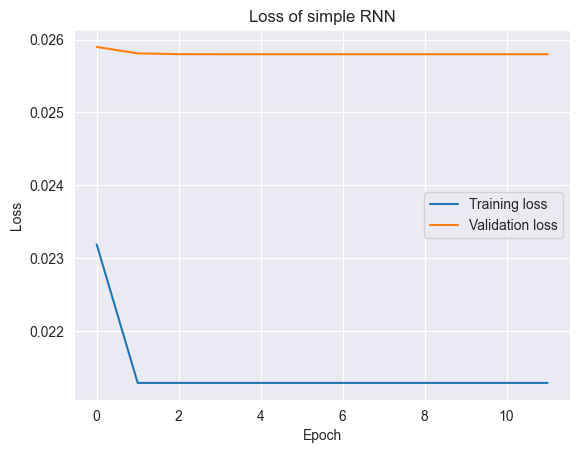

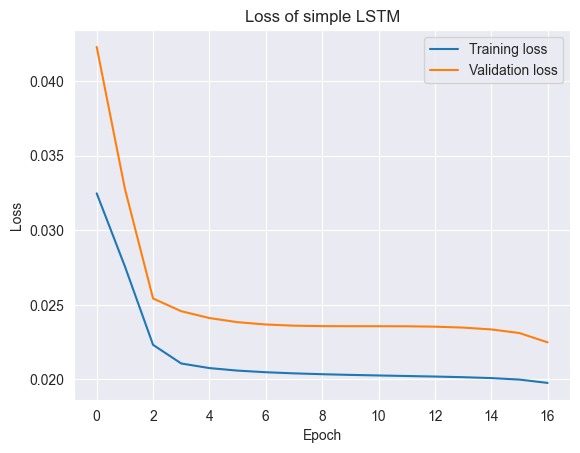

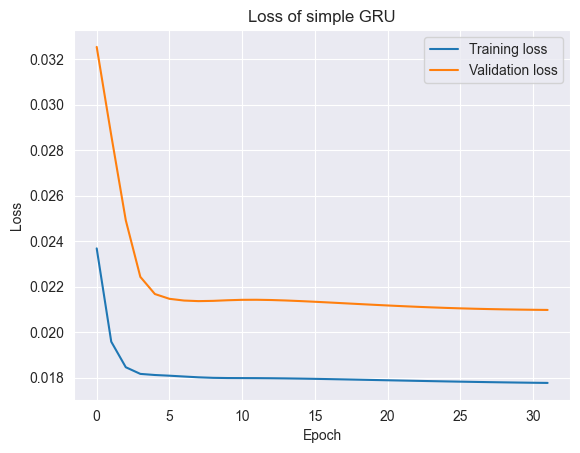

In [20]:
utils.plot_history(history_RNN, "Loss of simple RNN")
utils.plot_history(history_LSTM, "Loss of simple LSTM")
utils.plot_history(history_GRU, "Loss of simple GRU")

We evaluate the model on the test set. Remember that the mean absolute error (MAE) is scaled, so we need to inverse the scaling to get the actual value. That is not necessary for the mean absolute percentage error (MAPE).

In [21]:
test_loss, test_mae, test_mape = simple_model.evaluate(test_set_tf)
print(f"Simple RNN. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = simple_LST_model.evaluate(test_set_tf)
print(f"Simple LSTM. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = simple_GRU_model.evaluate(test_set_tf)
print(f"Simple GRU. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0490 - mae: 0.2506 - mape: 66.0292
Simple RNN. Test MAE: 772121. Test MAPE: 61.37.
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0349 - mae: 0.1820 - mape: 53.7519
Simple LSTM. Test MAE: 708372. Test MAPE: 43.75.
     27/Unknown 0s 4ms/step - loss: 0.0294 - mae: 0.1806 - mape: 61.0605

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0895 - mae: 0.2891 - mape: 65.5855
Simple GRU. Test MAE: 847406. Test MAPE: 79.92.


Let's take a look at the first few predictions on the test set, to see how our model is performing.

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


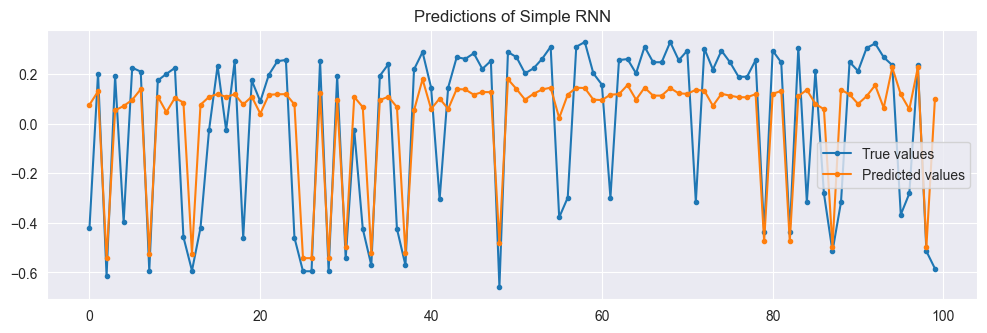

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


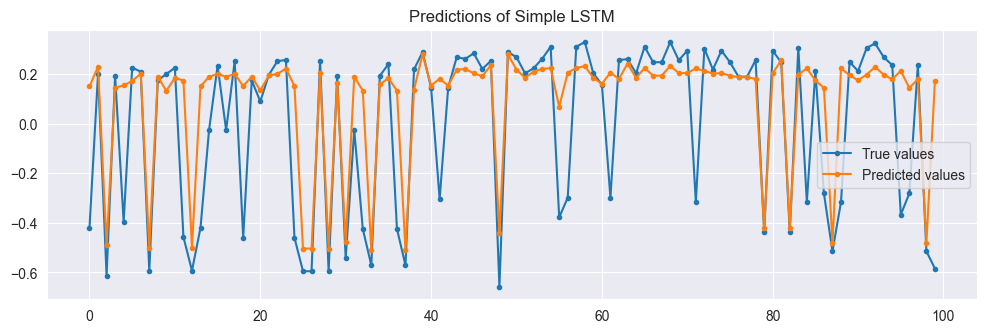

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


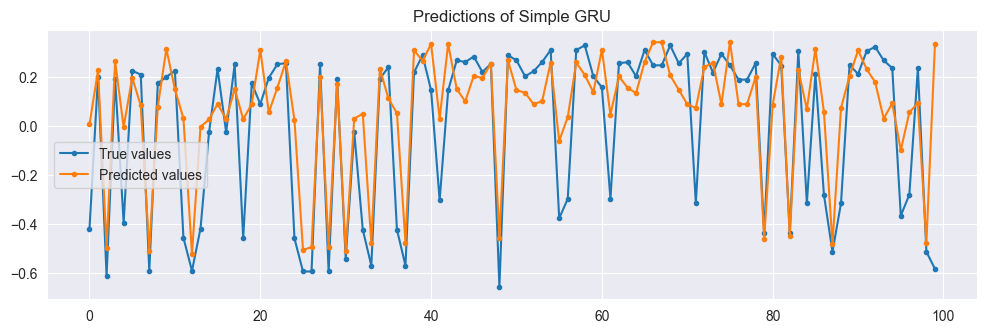

In [22]:
n_instances_to_plot = 100 
utils.plot_predictions(y_test, simple_model.predict(test_set_tf), n_instances_to_plot, title="Predictions of Simple RNN")
utils.plot_predictions(y_test, simple_LST_model.predict(test_set_tf), n_instances_to_plot, title="Predictions of Simple LSTM")
utils.plot_predictions(y_test, simple_GRU_model.predict(test_set_tf), n_instances_to_plot, title="Predictions of Simple GRU")

## Multiple simple recurrent neurons

Let's increase model complexity by adding more neurons to the models and a Dense layer at the end.

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

Multiple neurons with simple RNN units: None


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

Multiple neurons with simple LSTM units: None


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

Multiple neurons with simple GRU units: None
Epoch 1/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step - loss: 0.0158 - mae: 0.1097 - mape: 712.0419 - val_loss: 0.0479 - val_mae: 0.2594 - val_mape: 129.6659
Epoch 2/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - loss: 0.0074 - mae: 0.0704 - mape: 453.1997 - val_loss: 0.0339 - val_mae: 0.2190 - val_mape: 108.9011
Epoch 3/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 0.0069 - mae: 0.0671 - mape: 433.0986 - val_loss: 0.0318 - val_mae: 0.2101 - val_mape: 104.4555
Epoch 4/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - loss: 0.0068 - mae: 0.0662 - mape: 429.8134 - val_loss: 0.0329 - val_mae: 0.2091 - val_mape: 106.4599
Epoch 5/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - loss: 0.0069 - mae: 0.0673 - mape: 434.1877 - val_loss: 0.0291 - val_mae: 0.2017 - val_mape: 102.4908
Epoch 6/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - loss: 0.0067 - mae: 0.0657 - mape: 415.8633 - val_loss: 0.0273 - val_mae: 0.1957 - val_mape:

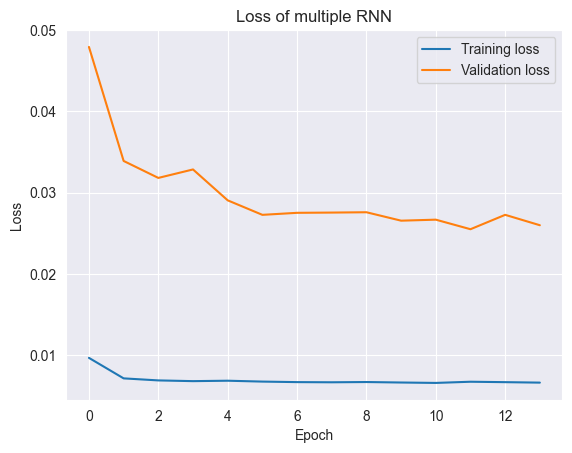

Epoch 1/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - loss: 0.0268 - mae: 0.1824 - mape: 1359.1417 - val_loss: 0.0459 - val_mae: 0.2631 - val_mape: 125.3346
Epoch 2/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - loss: 0.0142 - mae: 0.1267 - mape: 936.0001 - val_loss: 0.0403 - val_mae: 0.2419 - val_mape: 117.1810
Epoch 3/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - loss: 0.0117 - mae: 0.1097 - mape: 747.4800 - val_loss: 0.0418 - val_mae: 0.2454 - val_mape: 121.5465
Epoch 4/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 0.0102 - mae: 0.0996 - mape: 607.9446 - val_loss: 0.0462 - val_mae: 0.2556 - val_mape: 127.5580


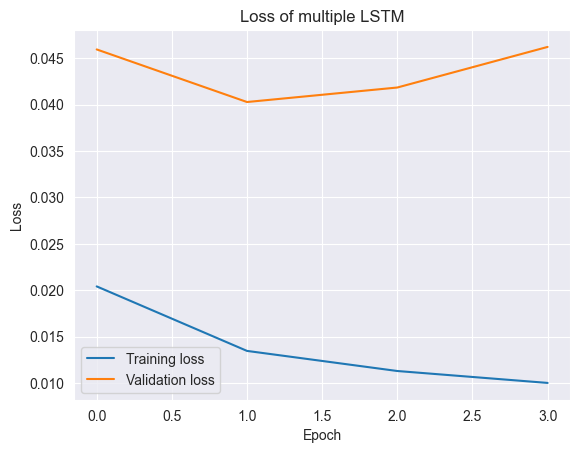

Epoch 1/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 102s 18ms/step - loss: 0.0220 - mae: 0.1613 - mape: 1086.9119 - val_loss: 0.0509 - val_mae: 0.2721 - val_mape: 128.2181
Epoch 2/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 100s 18ms/step - loss: 0.0146 - mae: 0.1277 - mape: 942.9238 - val_loss: 0.0402 - val_mae: 0.2378 - val_mape: 115.3323
Epoch 3/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 99s 18ms/step - loss: 0.0117 - mae: 0.1077 - mape: 693.3277 - val_loss: 0.0343 - val_mae: 0.2166 - val_mape: 110.0351
Epoch 4/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 98s 18ms/step - loss: 0.0099 - mae: 0.0958 - mape: 627.4475 - val_loss: 0.0327 - val_mae: 0.2111 - val_mape: 111.1488
Epoch 5/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 100s 18ms/step - loss: 0.0087 - mae: 0.0878 - mape: 621.2936 - val_loss: 0.0318 - val_mae: 0.2114 - val_mape: 111.3339
Epoch 6/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 100s 18ms/step - loss: 0.0076 - mae: 0.0776 - mape: 564.0456 - val_loss: 0.0319 - val_mae: 0.2155 - val_mape: 112.4108


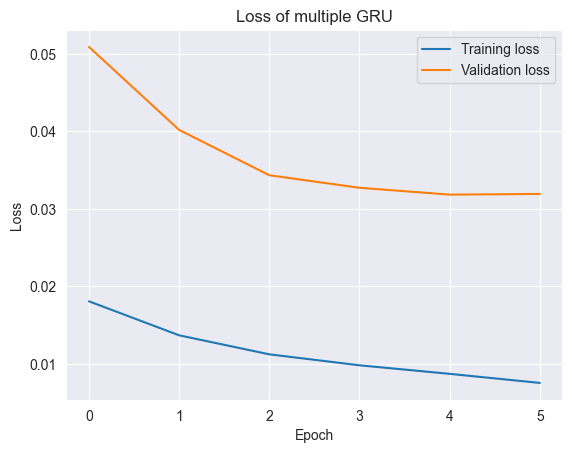

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0280 - mae: 0.1865 - mape: 74.8850
Multiple RNN. Test MAE: 698434. Test MAPE: 49.95.
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0526 - mae: 0.2590 - mape: 90.2515
Multiple LSTM. Test MAE: 760130. Test MAPE: 69.35.
     17/Unknown 0s 7ms/step - loss: 0.0128 - mae: 0.1205 - mape: 83.6669

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0433 - mae: 0.2261 - mape: 85.9526
Multiple GRU. Test MAE: 737283. Test MAPE: 62.82.
      1/Unknown 0s 165ms/step

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


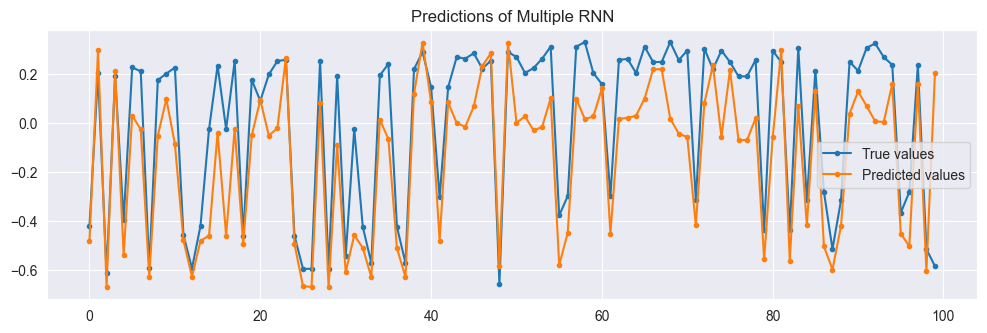

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


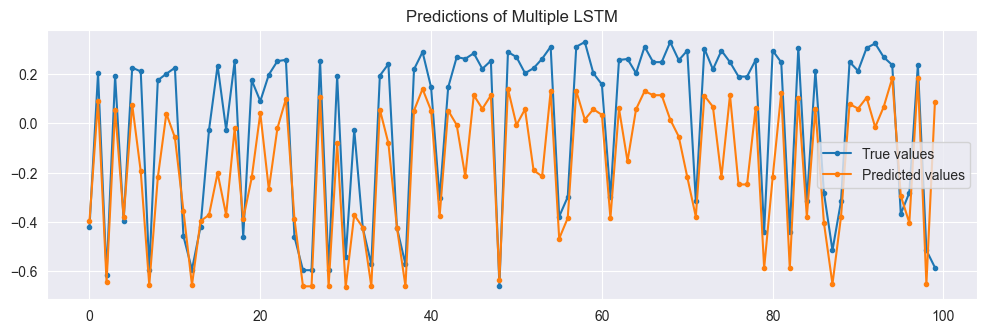

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


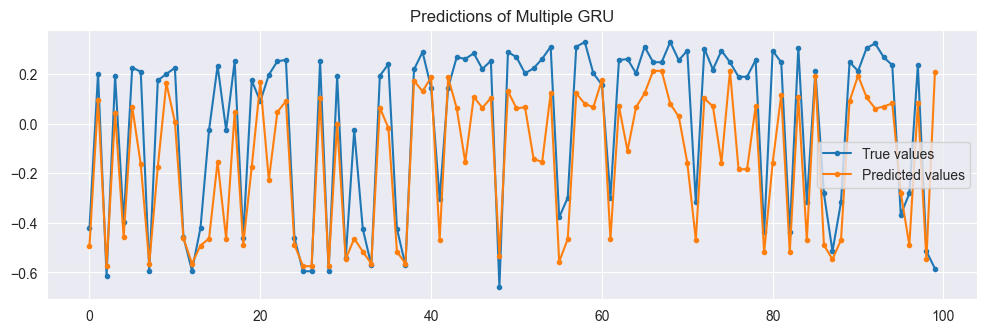

In [23]:
multi_model_RNN = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),  # tanh activation function by default
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Multiple neurons with simple RNN units:", multi_model_RNN.summary())
multi_model_LSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=[None, 4]),  # tanh activation function by default
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Multiple neurons with simple LSTM units:", multi_model_RNN.summary())
multi_model_GRU = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=[None, 4]),  # tanh activation function by default
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Multiple neurons with simple GRU units:", multi_model_RNN.summary())


# train the models
history_RNN = utils.train_model(multi_model_RNN, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_RNN, "Loss of multiple RNN")
history_LSTM = utils.train_model(multi_model_LSTM, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_LSTM, "Loss of multiple LSTM")
history_GRU = utils.train_model(multi_model_GRU, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_GRU, "Loss of multiple GRU")

# evaluate the model
test_loss, test_mae, test_mape = multi_model_RNN.evaluate(test_set_tf)
print(f"Multiple RNN. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = multi_model_LSTM.evaluate(test_set_tf)
print(f"Multiple LSTM. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = multi_model_GRU.evaluate(test_set_tf)
print(f"Multiple GRU. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")

utils.plot_predictions(y_test, multi_model_RNN.predict(test_set_tf), n_instances_to_plot, title="Predictions of Multiple RNN")
utils.plot_predictions(y_test, multi_model_LSTM.predict(test_set_tf), n_instances_to_plot, title="Predictions of Multiple LSTM")
utils.plot_predictions(y_test, multi_model_GRU.predict(test_set_tf), n_instances_to_plot, title="Predictions of Multiple GRU")

## Deep RNN

We increase the complexity further by stacking RNNs. We create a deep RNN with three layers. The last layer is a Dense layer with a single neuron (regression model).

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, None, 32)       │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

Deep model with simple RNN units None


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, None, 32)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, None, 32)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,409 (83.63 KB)

 Trainable params: 21,409 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

Deep model with LSTM units None


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, None, 32)       │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, None, 32)       │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,353 (63.88 KB)

 Trainable params: 16,353 (63.88 KB)

 Non-trainable params: 0 (0.00 B)

Deep model with GRU units None
Epoch 1/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - loss: 0.0205 - mae: 0.1351 - mape: 876.7791 - val_loss: 0.2360 - val_mae: 0.6421 - val_mape: 332.4012
Epoch 2/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 150s 28ms/step - loss: 0.0092 - mae: 0.0835 - mape: 459.6633 - val_loss: 0.1070 - val_mae: 0.3862 - val_mape: 194.6816
Epoch 3/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 152s 28ms/step - loss: 0.0081 - mae: 0.0746 - mape: 428.0324 - val_loss: 0.0820 - val_mae: 0.3279 - val_mape: 166.6590
Epoch 4/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 146s 27ms/step - loss: 0.0075 - mae: 0.0709 - mape: 486.6955 - val_loss: 0.0609 - val_mae: 0.2902 - val_mape: 147.8925
Epoch 5/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - loss: 0.0071 - mae: 0.0680 - mape: 535.9441 - val_loss: 0.0526 - val_mae: 0.2738 - val_mape: 138.1946
Epoch 6/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - loss: 0.0066 - mae: 0.0653 - mape: 495.3004 - val_loss: 0.0586 - val_mae: 0.2963 - val_mape: 144.75

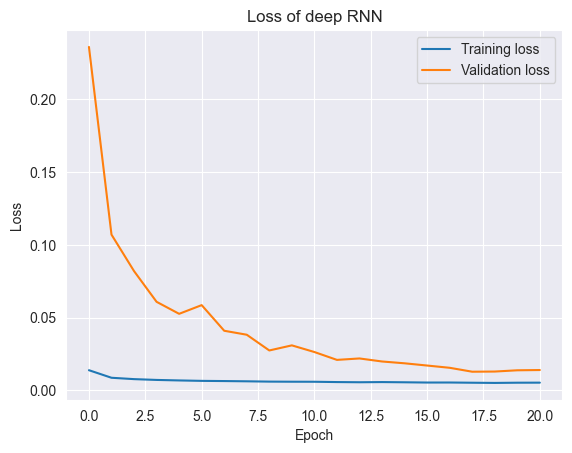

Epoch 1/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 234s 43ms/step - loss: 0.0426 - mae: 0.2473 - mape: 1949.1532 - val_loss: 0.1080 - val_mae: 0.4164 - val_mape: 199.9335
Epoch 2/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 227s 42ms/step - loss: 0.0227 - mae: 0.1614 - mape: 1656.4342 - val_loss: 0.0611 - val_mae: 0.3151 - val_mape: 148.5922
Epoch 3/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 228s 42ms/step - loss: 0.0115 - mae: 0.1014 - mape: 1213.7125 - val_loss: 0.0566 - val_mae: 0.3027 - val_mape: 145.9231
Epoch 4/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 228s 42ms/step - loss: 0.0094 - mae: 0.0865 - mape: 820.0644 - val_loss: 0.0627 - val_mae: 0.3142 - val_mape: 155.2508
Epoch 5/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 225s 42ms/step - loss: 0.0084 - mae: 0.0802 - mape: 539.0460 - val_loss: 0.0596 - val_mae: 0.3051 - val_mape: 153.6929


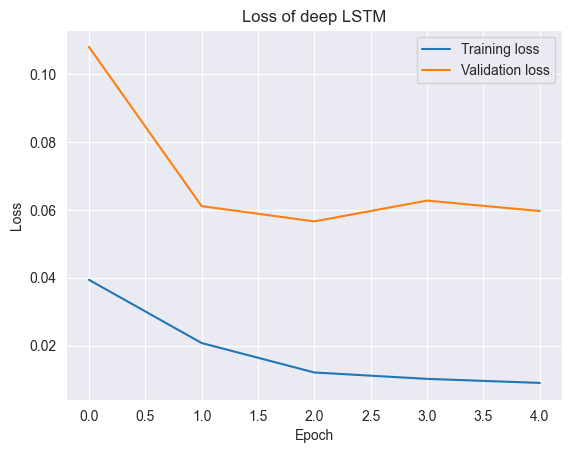

Epoch 1/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 292s 53ms/step - loss: 0.0299 - mae: 0.1923 - mape: 1362.2971 - val_loss: 0.0650 - val_mae: 0.3092 - val_mape: 158.0717
Epoch 2/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 287s 53ms/step - loss: 0.0145 - mae: 0.1265 - mape: 1235.5629 - val_loss: 0.0476 - val_mae: 0.2672 - val_mape: 129.6062
Epoch 3/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 286s 53ms/step - loss: 0.0098 - mae: 0.0921 - mape: 564.1671 - val_loss: 0.0465 - val_mae: 0.2672 - val_mape: 131.5779
Epoch 4/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 288s 53ms/step - loss: 0.0080 - mae: 0.0771 - mape: 453.7406 - val_loss: 0.0469 - val_mae: 0.2690 - val_mape: 135.0374
Epoch 5/500
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 287s 53ms/step - loss: 0.0072 - mae: 0.0699 - mape: 413.7902 - val_loss: 0.0471 - val_mae: 0.2687 - val_mape: 134.0852


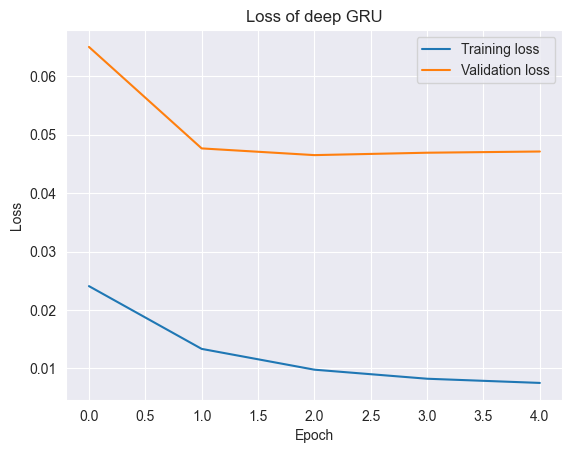

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0280 - mae: 0.1606 - mape: 52.4323
Deep RNN. Test MAE: 723642. Test MAPE: 47.09.
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.1742 - mae: 0.4495 - mape: 123.6276
Deep LSTM. Test MAE: 985216. Test MAPE: 125.53.
      4/Unknown 0s 23ms/step - loss: 0.0080 - mae: 0.1243 - mape: 38.8620

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0746 - mae: 0.3157 - mape: 106.3085
Deep GRU. Test MAE: 813645. Test MAPE: 83.83.


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step


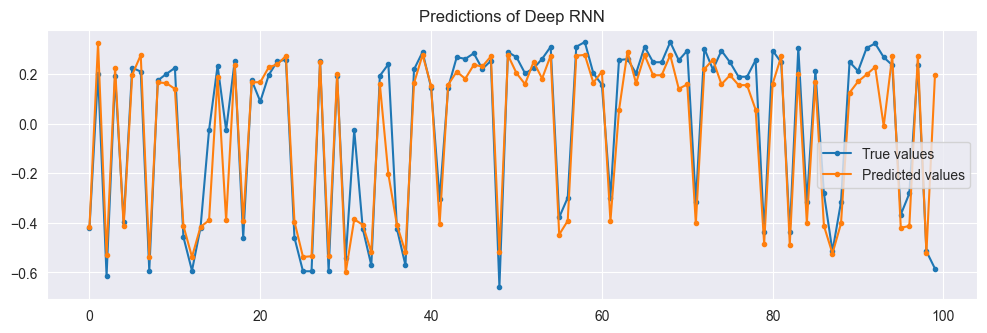

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step


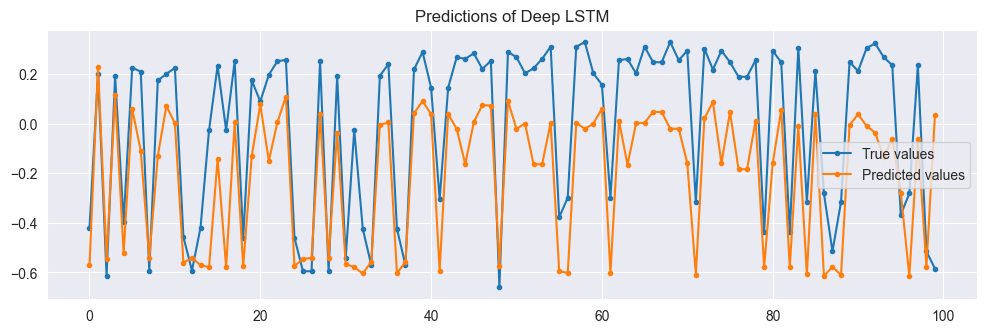

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step


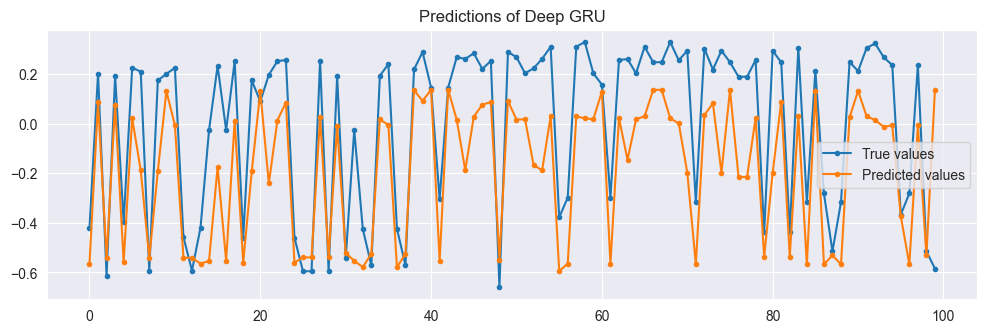

In [24]:
deep_model_RNN = tf.keras.Sequential([
    # return_sequences=True is used to return the output of each time step, not just the last one
    # in this way, the next layer can process the output of each time step (they can be stacked)
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4], return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Deep model with simple RNN units", deep_model_RNN.summary())
deep_model_LSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=[None, 4], return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Deep model with LSTM units", deep_model_LSTM.summary())
deep_model_GRU = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=[None, 4], return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Deep model with GRU units", deep_model_GRU.summary())

# train the model
history_RNN = utils.train_model(deep_model_RNN, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_RNN, "Loss of deep RNN")
history_LSTM = utils.train_model(deep_model_LSTM, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_LSTM, "Loss of deep LSTM")
history_GRU = utils.train_model(deep_model_GRU, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_GRU, "Loss of deep GRU")


# evaluate the model
test_loss, test_mae, test_mape = deep_model_RNN.evaluate(test_set_tf)
print(f"Deep RNN. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = deep_model_LSTM.evaluate(test_set_tf)
print(f"Deep LSTM. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = deep_model_GRU.evaluate(test_set_tf)
print(f"Deep GRU. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")

# plot the first few predictions on the test set
utils.plot_predictions(y_test, deep_model_RNN.predict(test_set_tf), n_instances_to_plot, title="Predictions of Deep RNN")
utils.plot_predictions(y_test, deep_model_LSTM.predict(test_set_tf), n_instances_to_plot, title="Predictions of Deep LSTM")
utils.plot_predictions(y_test, deep_model_GRU.predict(test_set_tf), n_instances_to_plot, title="Predictions of Deep GRU")

## ✨ Questions ✨ 

1. Are single-unit LSTM and GRU models improving the simple one? Why?
2. Are multiple and deep LSTM and GRU models improving the single-unit ones? Why?
3. What should be done to improve multiple and deep LSTM and GRU models?

### Answers

*Write your answers here.*

